In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models import BiGRU
from ANFISpy import GRUANFIS

## Pre-Processing

Importing and converting data.

In [2]:
df = pd.read_csv('brazil_covid19_macro.csv')
cases = df['cases'].values
dates = df['date'].values
days = np.array([i for i in range(cases.shape[0])], dtype='float32')

tick_indices = [i for i, d in enumerate(dates) if d.endswith('-01')]
tick_labels = [dates[i] for i in tick_indices]

Processing the data.

In [3]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

seq_len_bigru = 18

x_train, y_train = create_sequences(cases_train, seq_len_bigru)
x_test,  y_test  = create_sequences(cases_test, seq_len_bigru)

aligned_days_train = days_train[seq_len_bigru:]
aligned_days_test  = days_test[seq_len_bigru:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Instantianting BiGRU.

In [4]:
bigru = BiGRU(
    h=117,
    activation=nn.Identity(),
)

params_bigru = 0
for p in list(bigru.parameters()):
    params_bigru += p.flatten().shape[0]
    
print(f'Number of parameters: {params_bigru}')

Number of parameters: 84358


Training the model.

In [5]:
try:
    best_model_path = 'best_models/bigru.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True, map_location=torch.device('cpu'))
    bigru.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(bigru.parameters(), lr=0.000375)

    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/bigru.pth'

    for epoch in range(epochs):
        bigru.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = bigru(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 

        epoch_loss_train /= len(train_loader.dataset)

        if epoch_loss_train < best_train_loss:
                best_train_loss = epoch_loss_train
                torch.save({
                    'model_state_dict': bigru.state_dict(),
                }, best_model_path)

        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {best_train_loss:.8f}')

    checkpoint = torch.load(best_model_path, weights_only=True)
    bigru.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting training data predictions.

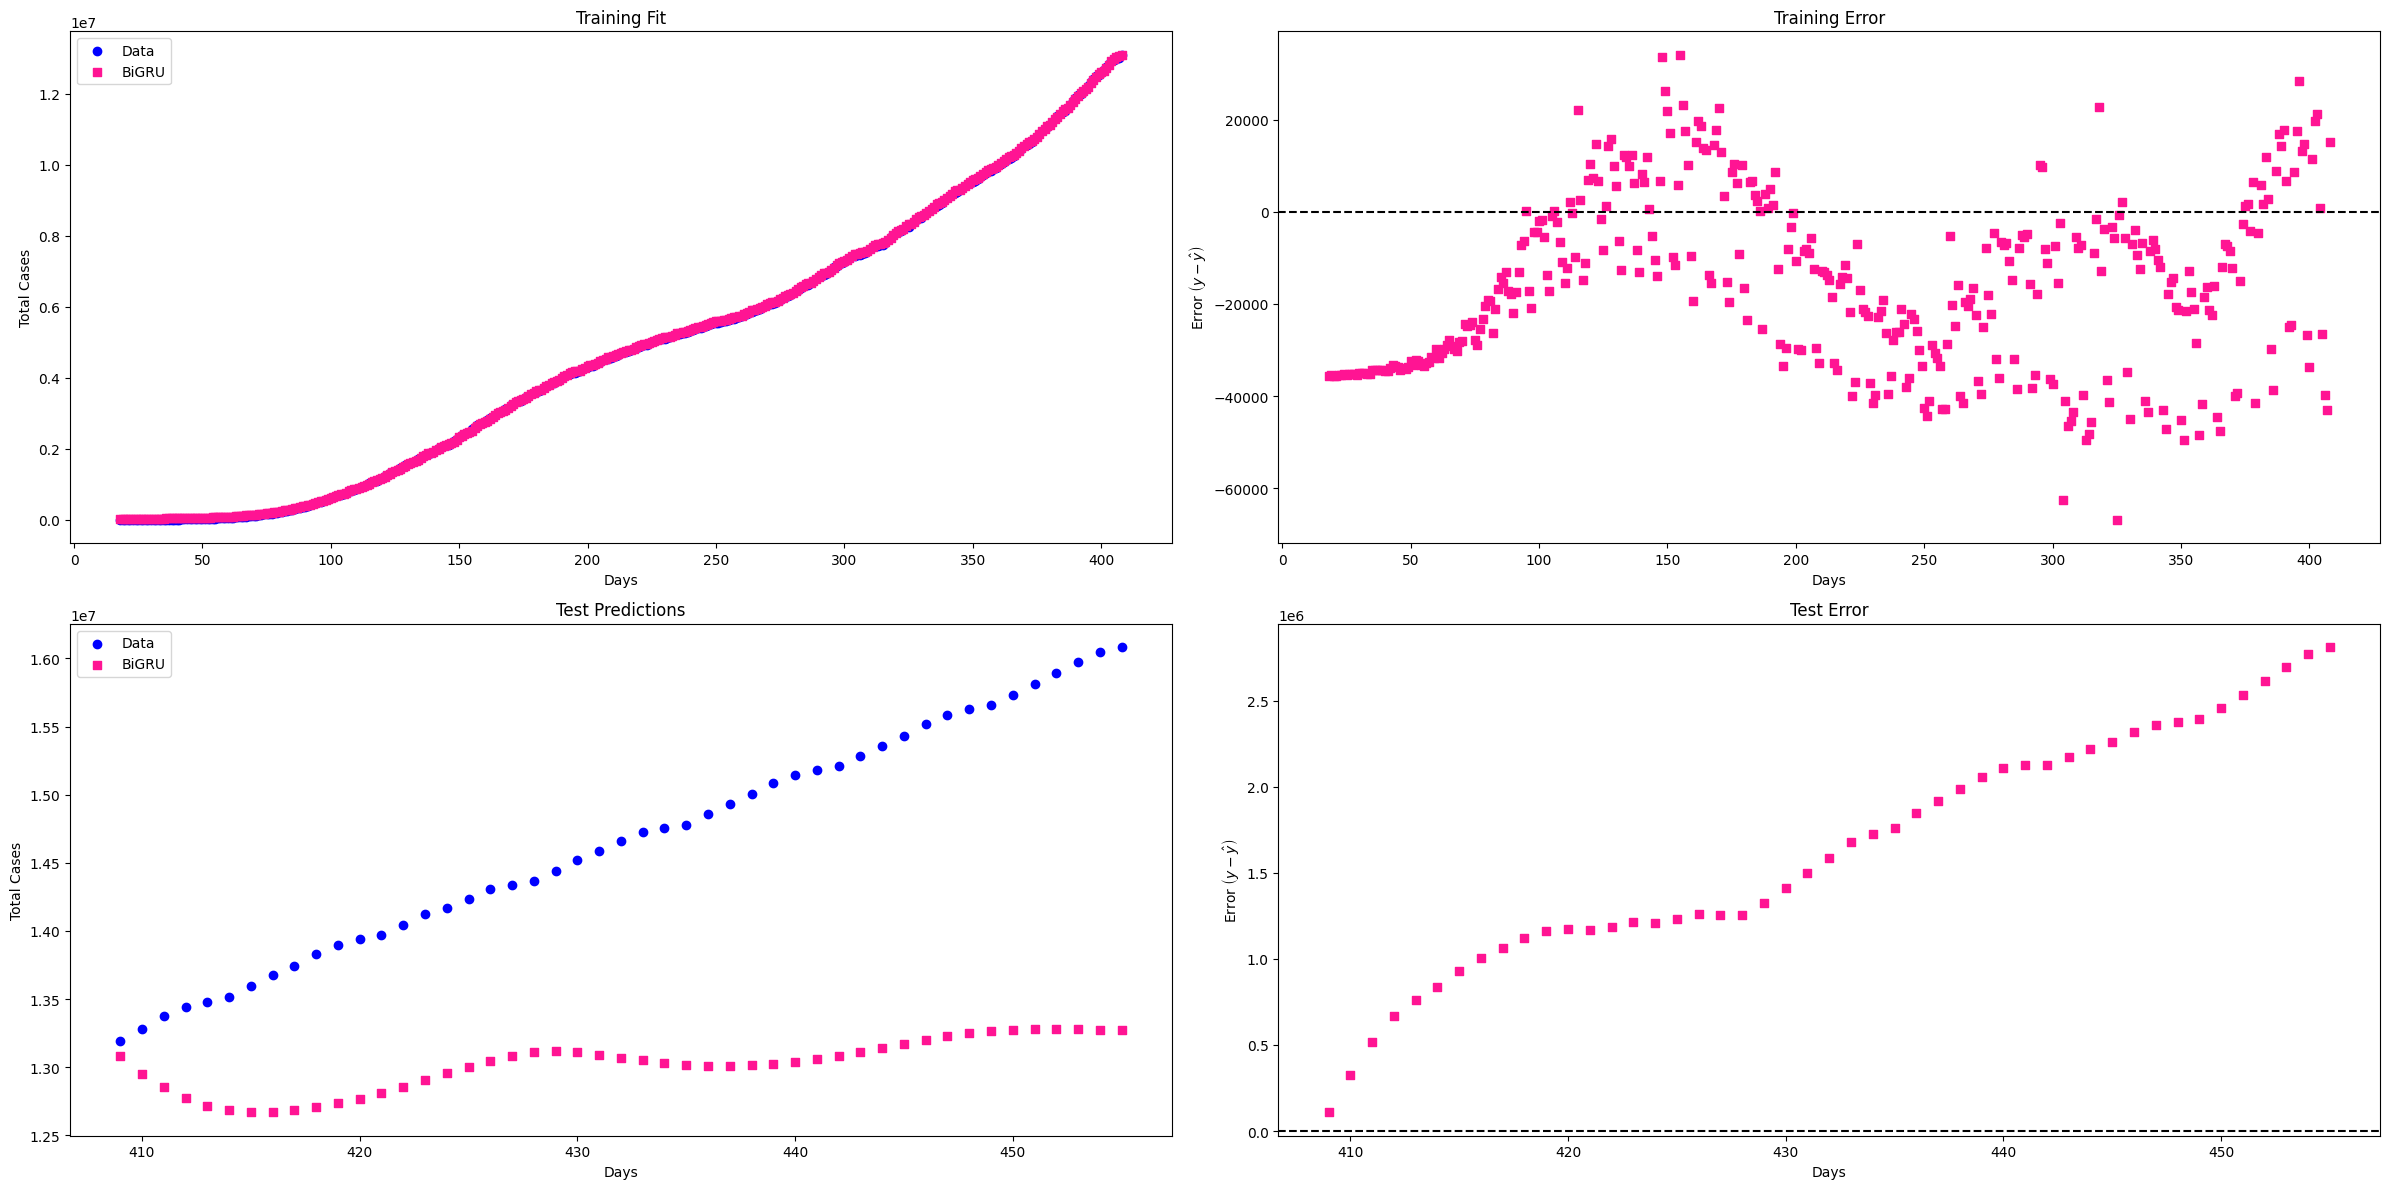

In [6]:
bigru.eval()
test_predictions_bigru = []

with torch.no_grad():
    train_predictions_bigru = bigru(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    h = None
    
    for _ in range(len(days_test)):  
        pred, hnew = bigru(last_data, h)  
        test_predictions_bigru.append(pred[:, -1:, 0].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)  
        h = hnew
        
train_predictions_bigru = train_predictions_bigru * (norm_max - norm_min) + norm_min
test_predictions_bigru = np.array(test_predictions_bigru) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_bigru:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(aligned_days_train, cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(aligned_days_train, train_predictions_bigru, label='BiGRU', marker='s', c='deeppink')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(aligned_days_train, cases_train_denorm - train_predictions_bigru, color='deeppink', marker='s')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_bigru, label='BiGRU', marker='s', c='deeppink')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_bigru, color='deeppink', marker='s')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## BiGRU-ANFIS

Instantiating model.

In [7]:
n_vars = 1
seq_len_bigruanfis = 14
mf_names = [['EL', 'VL', 'L', 'ML', 'M', 'MH', 'H', 'VH', 'EH']]

variables = {
    'inputs': {
        'n_sets': [9],
        'uod': n_vars * [(0, 1.5)],
        'var_names': ['Cases'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'New Cases',
        'n_classes': 1,
    },
}

bigruanfis = GRUANFIS(
    variables, 
    'bell', 
    seq_len_bigruanfis, 
    output_activation=nn.Identity(), 
    and_operator=torch.prod,
    bidirectional=True
)

params_bigruanfis = 0
for p in list(bigruanfis.parameters()):
    params_bigruanfis += p.flatten().shape[0]
    
print(f'Number of parameters: {params_bigruanfis}')

Number of parameters: 1125


Separating data.

In [8]:
total_len = len(cases)  
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

cases_train = cases[:train_size + val_size]
cases_test = cases[train_size + val_size:]

days_train = days[:train_size + val_size]
days_test = days[train_size + val_size:]

norm_min, norm_max = cases_train.min(), cases_train.max()

cases_train = (cases_train - norm_min) / (norm_max - norm_min)
cases_test  = (cases_test - norm_min) / (norm_max - norm_min)

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])     
        y.append(data[i + 1 : i + seq_length + 1])  
    x = torch.FloatTensor(np.array(x)).unsqueeze(-1) 
    y = torch.FloatTensor(np.array(y)).unsqueeze(-1)
    return x, y

x_train, y_train = create_sequences(cases_train, seq_len_bigruanfis)
x_test,  y_test  = create_sequences(cases_test, seq_len_bigruanfis)

aligned_days_train = days_train[seq_len_bigruanfis:]
aligned_days_test  = days_test[seq_len_bigruanfis:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

Training.

In [9]:
try:
    best_model_path = 'best_models/bigruanfis.pth'  
    checkpoint = torch.load(best_model_path, weights_only=True)
    bigruanfis.load_state_dict(checkpoint['model_state_dict'])
    print('Loaded.')

except:
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(bigruanfis.parameters(), lr=0.008174)
    
    epochs = 1000
    best_train_loss = float('inf')
    best_model_path = 'best_models/bigruanfis.pth'
    
    for epoch in range(epochs):
        bigruanfis.train()
        epoch_loss_train = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = bigruanfis(X_batch)[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item() * X_batch.size(0) 
    
        epoch_loss_train /= len(train_loader.dataset)
    
        if epoch_loss_train < best_train_loss:
            best_train_loss = epoch_loss_train
            torch.save({
                'model_state_dict': bigruanfis.state_dict(),
            }, best_model_path)
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Train Loss: {best_train_loss:.8f}')
    
    checkpoint = torch.load(best_model_path, weights_only=True)
    bigruanfis.load_state_dict(checkpoint['model_state_dict'])

Loaded.


Plotting.

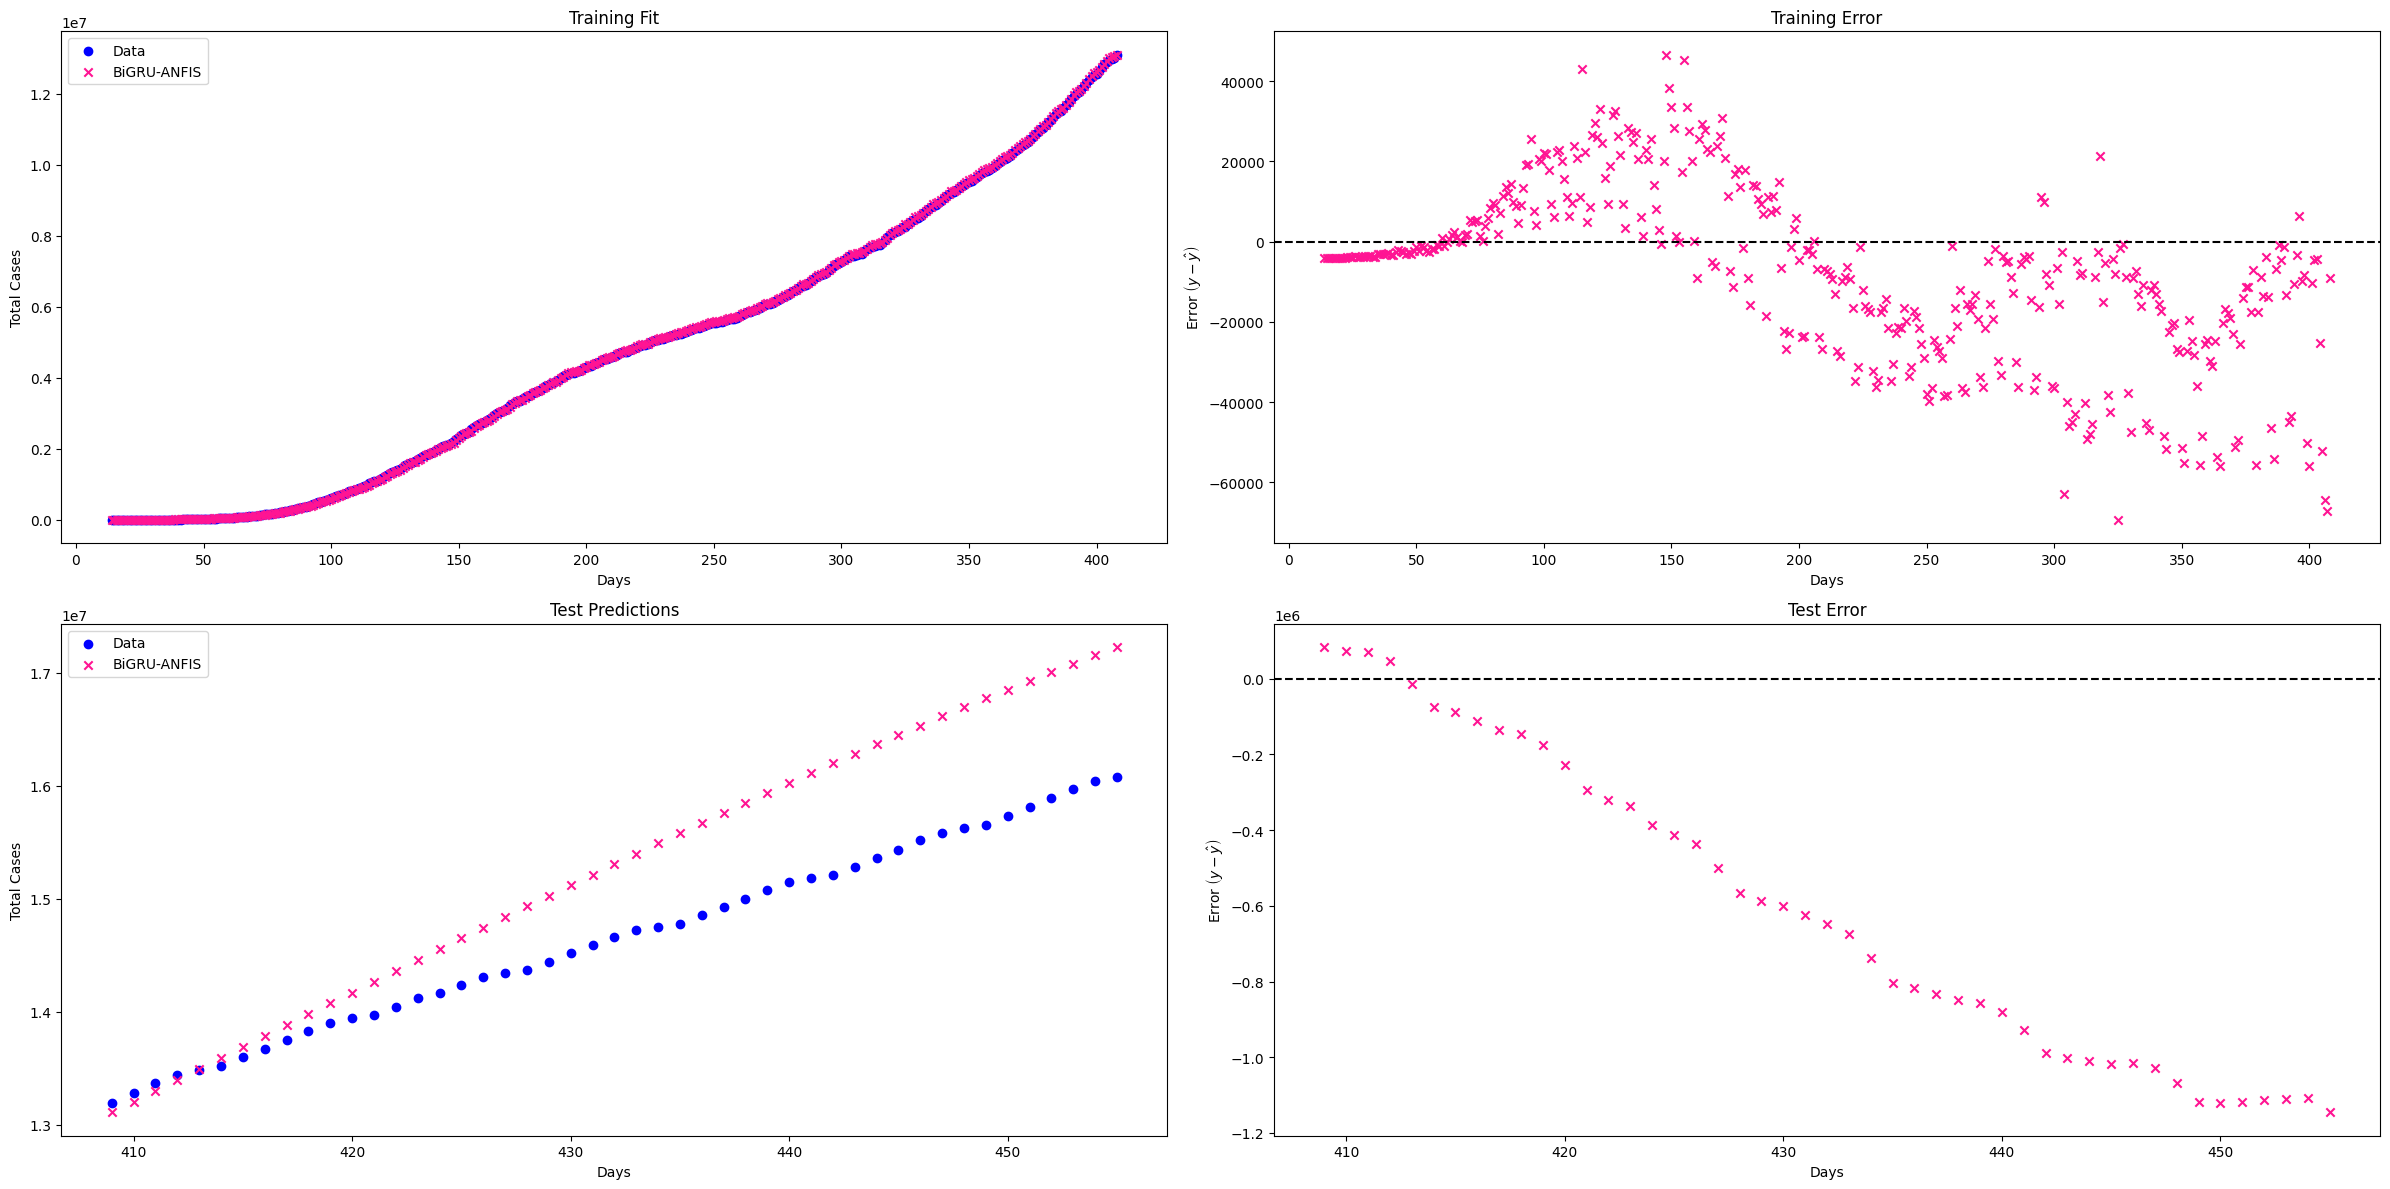

In [10]:
bigruanfis.eval()
test_predictions_bigruanfis = []

with torch.no_grad():
    train_predictions_bigruanfis = bigruanfis(x_train)[0][:, -1, :].numpy().flatten()
    
    last_data = x_train[-1:]
    h = None
    
    for _ in range(len(days_test)):  
        pred, hnew = bigruanfis(last_data, h)  
        test_predictions_bigruanfis.append(pred[:, -1:, :].item())
        last_data = torch.cat([last_data[:, 1:, :], pred[:, -1:, :]], dim=1)  
        h = hnew
        
train_predictions_bigruanfis = train_predictions_bigruanfis * (norm_max - norm_min) + norm_min
test_predictions_bigruanfis = np.array(test_predictions_bigruanfis) * (norm_max - norm_min) + norm_min

cases_train_denorm = cases_train[seq_len_bigruanfis:] * (norm_max - norm_min) + norm_min
cases_test_denorm = cases_test * (norm_max - norm_min) + norm_min

fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 0].scatter(aligned_days_train, cases_train_denorm, label='Data', c='blue')
ax[0, 0].scatter(aligned_days_train, train_predictions_bigruanfis, label='BiGRU-ANFIS', marker='x', c='deeppink')
ax[0, 0].set_title("Training Fit")
ax[0, 0].set_xlabel("Days")
ax[0, 0].set_ylabel("Total Cases")
ax[0, 0].legend()

ax[0, 1].scatter(aligned_days_train, cases_train_denorm - train_predictions_bigruanfis, color='deeppink', marker='x')
ax[0, 1].axhline(0, color='black', linestyle='--')
ax[0, 1].set_title("Training Error")
ax[0, 1].set_xlabel("Days")
ax[0, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

ax[1, 0].scatter(days_test, cases_test_denorm, label='Data', c='blue')
ax[1, 0].scatter(days_test, test_predictions_bigruanfis, label='BiGRU-ANFIS', marker='x', c='deeppink')
ax[1, 0].set_title("Test Predictions")
ax[1, 0].set_xlabel("Days")
ax[1, 0].set_ylabel("Total Cases")
ax[1, 0].legend()

ax[1, 1].scatter(days_test, cases_test_denorm - test_predictions_bigruanfis, color='deeppink', marker='x')
ax[1, 1].axhline(0, color='black', linestyle='--')
ax[1, 1].set_title("Test Error")
ax[1, 1].set_xlabel("Days")
ax[1, 1].set_ylabel(r"Error $\left(y - \hat{y}\right)$")

plt.tight_layout()
plt.show()

## Final Analysis

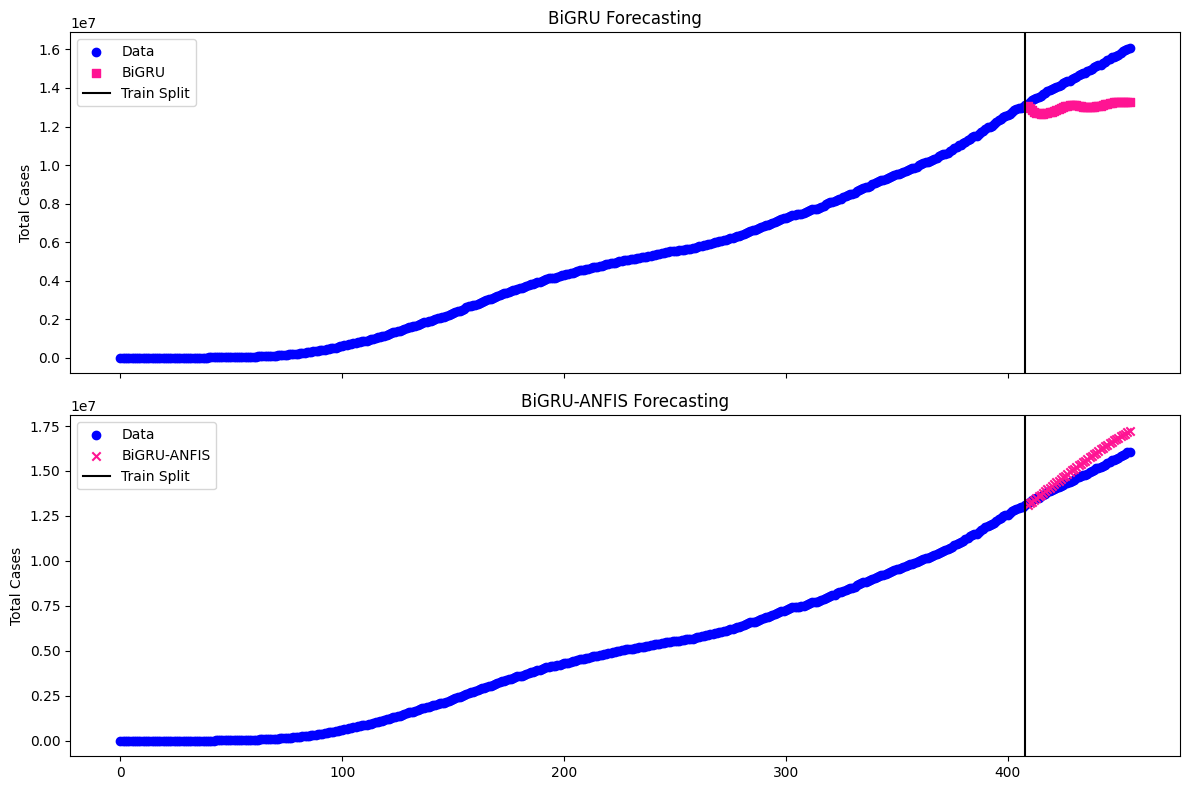

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].scatter(days, cases, label='Data', color='blue')
ax[0].scatter(days_test, test_predictions_bigru, label='BiGRU', color='deeppink', marker='s')
ax[0].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[0].set_title('BiGRU Forecasting')
ax[0].set_ylabel('Total Cases')
ax[0].legend()

ax[1].scatter(days, cases, label='Data', color='blue')
ax[1].scatter(days_test, test_predictions_bigruanfis, label='BiGRU-ANFIS', color='deeppink', marker='x')
ax[1].axvline(days_train.max(), linestyle='-', color='black', label='Train Split')
ax[1].set_title('BiGRU-ANFIS Forecasting')
ax[1].set_ylabel('Total Cases')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
rmse_bigru = np.sqrt(np.mean((cases_test_denorm - test_predictions_bigru)**2)).item()
rmse_bigruanfis = np.sqrt(np.mean((cases_test_denorm - test_predictions_bigruanfis)**2)).item()
mae_bigru = np.mean(np.abs(cases_test_denorm - test_predictions_bigru)).item()
mae_bigruanfis = np.mean(np.abs(cases_test_denorm - test_predictions_bigruanfis)).item()
mape_bigru = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_bigru) / cases_test_denorm)).item()
mape_bigruanfis = 100 * np.mean(np.abs((cases_test_denorm - test_predictions_bigruanfis) / cases_test_denorm)).item()

print(f'BiGRU       | RMSE: {int(rmse_bigru)} | MAE: {int(mae_bigru)} | MAPE: {mape_bigru:.2f}% | Parameters: {params_bigru}')
print(f'BiGRU-ANFIS | RMSE: {int(rmse_bigruanfis)}  | MAE: {int(mae_bigruanfis)}  | MAPE: {mape_bigruanfis:.2f}%  | Parameters: {params_bigruanfis}')

BiGRU       | RMSE: 1764712 | MAE: 1629318 | MAPE: 10.90% | Parameters: 84358
BiGRU-ANFIS | RMSE: 732124  | MAE: 623342  | MAPE: 4.12%  | Parameters: 1125
